**After this laboratory you should be able to**
- Explain the task of **Node-classification**
- Explain the **Classifier framework**
- Understand the techniques provided

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from scipy.io import mmread
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os, sys
import urllib.request
import io
import zipfile
import random
from tqdm import tqdm

from sklearn.metrics import accuracy_score

In [2]:
parent_dir = os.path.abspath(os.path.join('..'))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)
    
from utils.utils import average_clustering, average_degree, connectivity_perc, giant_component, print_stats

## Utils

# Node clasification

**Task**  
We are given a graph where some of the nodes have labels(categorical, numerical, binary) and some don't. Our task is to label the remaining nodes.

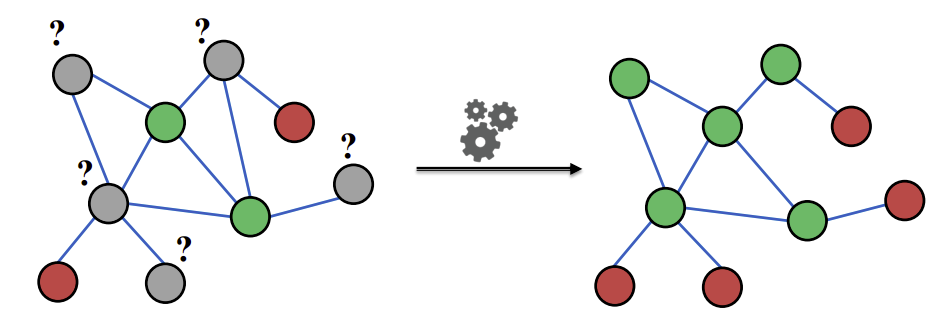

**Assumption about the data:** Similar nodes (with similar label) are connected. We want to exploit this fact.

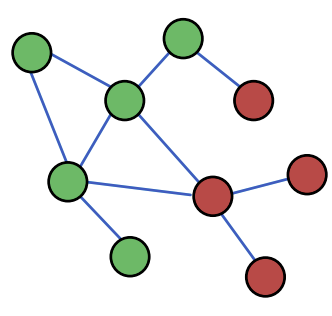

We encounter 2 phenomena:
1. **Homophily**  
    Nodes (individuals) that have similar characteristics are connected and probably have the same label -- *birds of the same feather flock together*. Ex: Researchers who focus on the same area tend to make friendships
2. **Influence**  
    Social connections influence the individual characteristics. Ex: I recommend my musical preferences to my friends -> they might like it
    
**What do we look at when we classify?**
- The node's features
- The neighbours labels
- The neighbours features

**Techniques**
1. Relational classification
2. Iterative classification
3. Belief propagation

## Classifier framework

**Local classifier** -- Assign initial labels
- Predicts labels based on node attributes / festures
- Does not use network information

**Relational classifier** -- Capture correlations between nodes
- Learns a classifier to label one node based on label / features of the neighbours
- Uses network information

**Collective inference** -- Propagate the correlation
- Apply relational classifier to each node itaretively
- Iterate until the inconsistency between neighboring labels is minimized


Workflow
1. The **local classifier** is applied once at the beginning
2. Apply the **relational classifier** and **collective inteligence** iteratively for a number of steps or until a stopping condition

## Relational classifier

*Intuition*: Weighted average of the neighbours labels. 

This classifier will only look at the nodes labels. We are not going to use the attributes.

**Classifier**  
Consider the task of binary classification. We are given a graph $G$ and some of the nodes are labeled
1. Initialization
    - for labeled nodes $v$ let $Y_v \in {0, 1}$ be the label. For unlabeled nodes we initalize their label with a uniform value (0.5)
2. Update rule
    $$P(Y_v = c) = \dfrac 1 {\sum_{(v, u) \in E}A_{v,u}}\sum_{(v,u) \in E}A_{v,u}P(Y_u = c)$$
    where 
    - $A$ is the weight matrix. For an unweighted graph this is the adjacency matrix 
    - $P(Y_v = c)$ -- Probability that node $v$ has label $c$
    - $\sum_{(v, u) \in E}A_{v,u}$ -- Sum of neighbour edge weights. For unweighted graph this is the node degree / in-degree. This is a normalizing factor
    - $\sum_{(v,u) \in E}A_{v,u}P(Y_u = c)$ -- Sum the edge weight to the neighbour node $u$ times the probability of that node being in class $c$
    
**Problems**
- Convergence is not guaranteed
- Model cannot use node feature information

### Run one iteration

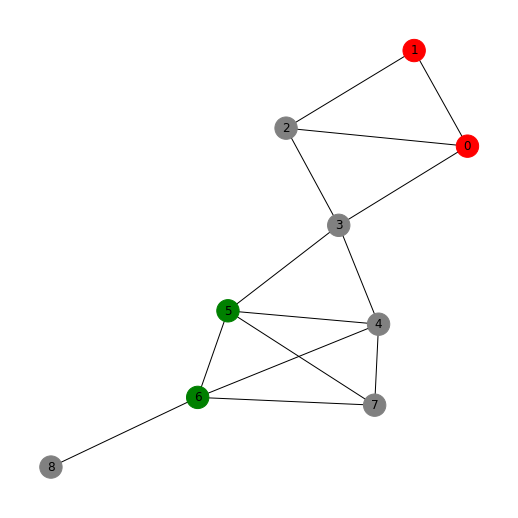

In [3]:
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (4, 7), (5, 7), (5, 6), (6, 7), (6, 8)]
G = nx.Graph(edges)

train_nodes = [0, 1, 5, 6]
test_nodes = [u for u in G.nodes if u not in train_nodes]
y_train = [0, 0, 1, 1]

node_color = ['grey'] * G.number_of_nodes()
for v, yv in zip(train_nodes, y_train):
    if yv == 0:
        node_color[v] = 'red'
    else:
        node_color[v] = 'green'

plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, with_labels=True, node_color = node_color, node_size = 500)


In [4]:
def init_probs(G, train_nodes, y_train):
    probs = [0.5] * G.number_of_nodes()
    for i, (v, yv) in enumerate(zip(train_nodes, y_train)):
        probs[v] = yv
    return probs
    

In [5]:
probs = init_probs(G, train_nodes, y_train)
print(probs)

[0, 0, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5]


In [6]:
def update(G, train_nodes, probs):
    probs = probs.copy()
    converged = train_nodes
    for v in G.nodes:
        if v not in converged:
            probs[v] = 1 / G.degree(v) * sum(probs[u] for u in G.neighbors(v))
    return probs

In [7]:
probs_ = update(G, train_nodes, probs)
print(probs_)

[0, 0, 0.16666666666666666, 0.41666666666666663, 0.7291666666666666, 1, 1, 0.9097222222222221, 1.0]


### Binary Relational Classifier model

In [8]:
class BinaryRelationalClassifier:
    def __init__(self, tol = .01):
        """
        Binary relational classifier
        
        Arguments
            tol: {float} default=.01 -- Convergence tolerance. If the future label prob didn't change with at least `tol` it converged
        """
        self.converged = []
        self.tol = tol
        self.probs = []
    
    def init_probs(self, G, train_nodes, y_train):
        """
        Computes inital probabilities. Assigns 1 and 0 to labelled nodes and .5 to unlabelled ones
        
        Arguments:
            G: {nx.Graph} -- Undirected graph
            train_nodes: {list} -- List of training nodes from the graph G
            y_train: {list} -- list of training labels. All labels must be in [0, 1]
            
        Return
            probs: {list} -- List of inital probabilities
        """
        self.converged = train_nodes.copy()
        probs = [0.5] * G.number_of_nodes()
        for i, (v, yv) in enumerate(zip(train_nodes, y_train)):
            probs[v] = float(yv)
        self.probs = probs
    
    def update(self, G):
        """
        Update step. Computes the future probabilities and marks convergent nodes
        """
        probs = self.probs
        future_probs = probs.copy()
        for v in G.nodes:
            if v not in self.converged:
                future_probs[v] = 1 / G.degree(v) * sum(probs[u] for u in G.neighbors(v))
                
                # Mark convergent if 
                if abs(future_probs[v] - probs[v]) < self.tol:
                    self.converged.append(v)
        self.probs = future_probs
    
    
    
    def fit(self, graph, train_nodes, y_train, steps = 10):
        """
        Fits a classifier on a graph
        
        Arguments
            graph: {nx.Graph} -- Undirected graph
            train_nodes: {list} -- List of training nodes from the graph G
            y_train: {list} -- list of training labels. All labels must be in [0, 1]
        Result
            {BinaryClassificationModel} -- Returns the model
        """
        G = graph.copy()
        assert len(train_nodes) == len(y_train), "Number of labels must be the same as number of training nodes"
        assert all(yv in [0, 1] for yv in y_train), "Labels must be in [0, 1]"
        assert all(u in G.nodes for u in train_nodes), "Nodes must be in the given graph"
        
        # Get starting probs
        self.init_probs(G, train_nodes, y_train)
        # Update
        for step in range(steps):
            if len(self.converged) == G.number_of_nodes(): # Break if we reach convergence
                break
            self.update(G)
            
        return self
    
    def predict(self, G, test_nodes):
        """
        Return predicted labels of test_nodes
        """
        assert all(u in G.nodes for u in test_nodes), "Nodes must be in the given graph"
        return [round(self.probs[v]) for v in test_nodes]
    
    def predict_proba(self, G, test_nodes):
        """
        Return predicted probabilities of test_nodes
        """
        assert all(u in G.nodes for u in test_nodes), "Nodes must be in the given graph"
        return [self.probs[v] for v in test_nodes]
        

In [9]:
model = BinaryRelationalClassifier()
model.fit(G, train_nodes, y_train)
preds = model.predict(G, G.nodes)

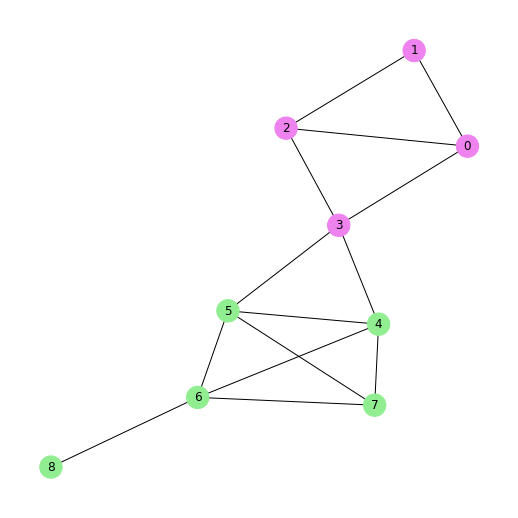

In [10]:
node_color = [''] * G.number_of_nodes()
for v, yv in zip(G.nodes, preds):
    if yv == 0:
        node_color[v] = 'violet'
    else:
        node_color[v] = 'lightgreen'

plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, with_labels=True, node_color = node_color, node_size = 500)

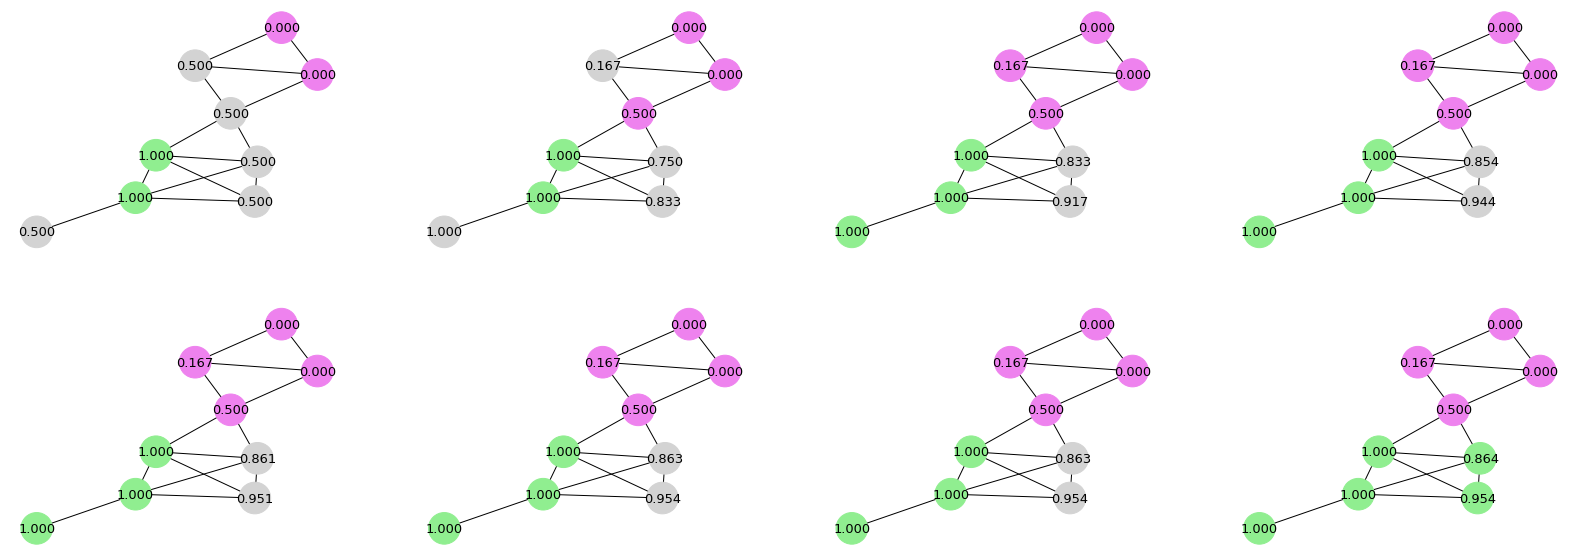

In [11]:
# Step by step

model = BinaryRelationalClassifier(tol = .0005)
model.init_probs(G, train_nodes, y_train)

steps = 8
plt.figure(figsize = (7 * 4, 10))

for step in range(steps):
    
    converged_nodes = model.converged
    converged_labels = model.predict(G, converged_nodes)
    
    node_color = ['lightgrey'] * G.number_of_nodes()
    for v, yv in zip(converged_nodes, converged_labels):
        if yv == 0:
            node_color[v] = 'violet'
        else:
            node_color[v] = 'lightgreen'
    
    nodeplt_labels = {u: f"{p:.3f}" for u, p in zip(G.nodes, model.predict_proba(G, G.nodes))}
    
    
    model.update(G)
    
    plt.subplot(2, 4, step+1)
    nx.draw_kamada_kawai(G, with_labels=True, labels = nodeplt_labels, node_color = node_color, node_size = 1000, font_size = 13)
    


### Real dataset

In [12]:
from karateclub.dataset import GraphReader


In [13]:
name = "twitch" #  "wikipedia"
G = GraphReader(name).get_graph()
X = GraphReader(name).get_features()
y = GraphReader(name).get_target()

print(np.unique(y, return_counts=True))

(array([0, 1], dtype=int64), array([3238, 3888], dtype=int64))


In [14]:
print_stats(G, 100)

G.number_of_nodes() = 7126
G.number_of_edges() = 35324
average_degree(G) = 9.91
average_clustering(G) = 0.1309
connectivity_perc(G) = 1.00
average_shortest_path_length_sampled(G, n_samples) = 4.0


In [15]:
train_num = int(.8 * len(G.nodes))
train_nodes = list(np.random.choice(G.nodes, size = train_num, replace = False))
test_nodes = [u for u in G.nodes if u not in train_nodes]

y_train = y[train_nodes]
y_test  = y[test_nodes]

In [16]:
model = BinaryRelationalClassifier()
model.fit(G, list(train_nodes), list(y_train))

In [17]:
len(model.converged) == len(G)

True

In [18]:
preds = model.predict(G, test_nodes)
print(accuracy_score(y_test, preds))

0.5596072931276297


## Iterative classification

*Intuition*: We want to use node attributes too. We will classify note $v$ based on attributes $f_v$ as well as the labels of the neighbours of $v$ encoded in $z_v$. Therefore we will use 2 classifiers

Input: Graph
- with feature vectors for nodes
- some of the nodes are labeled

**Task**: We want to predict unlabeled nodes

**Classifier 1**  $\phi_1(f_v)$ -- Predicts $v$ label based on the feature vector $f_v$
- Can be a linear classifier, nn, svm, random forest etc

**Classifier 2**  $\phi_2(f_v, z_v)$ -- PRedicts $v$ label based on the feature vector $f_v$ and summary of $v's$ neighbours labels $z_v$
- What $z_v$ be? It can be whatever we want! A histogram of the each label in the neighbourhood, most common label in the neighbourhood, number of different labels etc

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from karateclub import FeatherNode, MUSAE, AE
from sklearn.preprocessing import StandardScaler


In [20]:
name = "twitch" #  "wikipedia"
G = GraphReader(name).get_graph()
X = GraphReader(name).get_features()
y = GraphReader(name).get_target()

print(G)
print(np.unique(y, return_counts=True))

Graph with 7126 nodes and 35324 edges
(array([0, 1], dtype=int64), array([3238, 3888], dtype=int64))


In [ ]:
X_ = X.copy()

In [322]:
#encoder = FeatherNode(reduction_dimensions=1)
#encoder = MUSAE(dimensions=5)
encoder = AE(walk_number=5, walk_length=20, dimensions=4, window_size=3, epochs=2)
encoder.fit(G, X_)

In [323]:
X = encoder.get_embedding()
X.shape

(7126, 8)

In [21]:
## Generate some data

# l communities with k nodes each
num_communities = 3
num_nodes_per_community = 32
G = nx.planted_partition_graph(l = num_communities, k = num_nodes_per_community, p_in = 0.5, p_out = 0.1, seed=42)
len(G)
colors = ['violet', 'lightgreen', 'lightblue', 'yellow']
node_color = [colors[v] for v in nx.get_node_attributes(G, 'block').values()]
y = np.array(list(nx.get_node_attributes(G, 'block').values()))

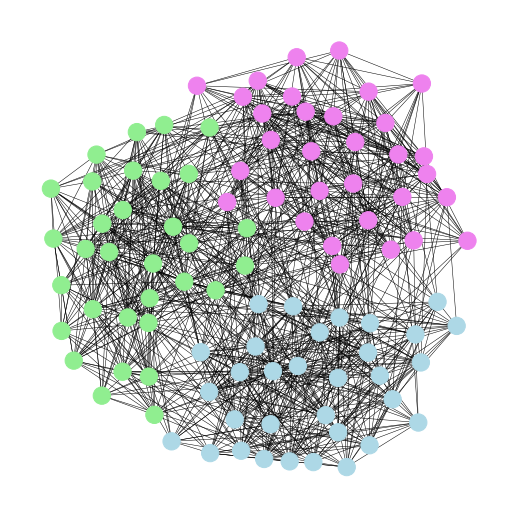

In [22]:
plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)

In [23]:
## Generate some features

n_features = 10
X, y_ = make_classification(
    n_samples = num_communities * num_nodes_per_community,
    n_classes = num_communities,
    n_features = n_features,
    n_informative= n_features,
    n_redundant=0,
    n_clusters_per_class=1,
    shuffle=False
)
X = StandardScaler().fit_transform(X)

In [24]:
print(all(y == y_))
np.unique(y_, return_counts=True)

False


(array([0, 1, 2]), array([30, 34, 32], dtype=int64))

In [26]:
#plt.scatter(*X.T, c = node_color)

In [27]:
X_train, X_test, y_train, y_test, train_nodes, test_nodes = train_test_split(X, y, list(G.nodes), test_size=.8, random_state=42)

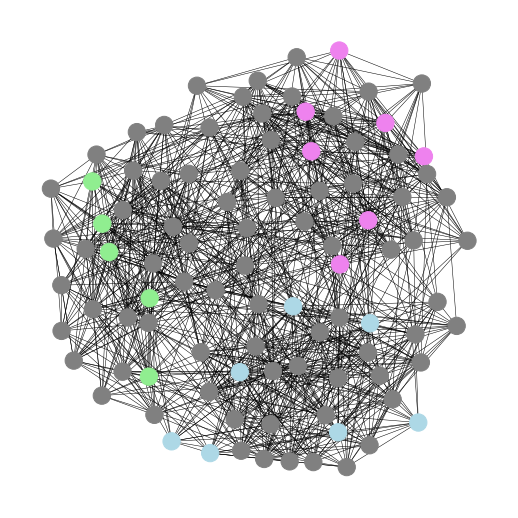

In [28]:
node_color = [colors[v] for v in nx.get_node_attributes(G, 'block').values()]
for v in test_nodes:
    node_color[v] = 'grey'
    
plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)

### One step

In [29]:
phi1 = GradientBoostingClassifier().fit(X_train, y_train)

In [30]:
preds = phi1.predict(X_test)
accuracy_score(y_test, preds)

0.6233766233766234

In [31]:
def compute_zv(G, y):
    num_classes = len(np.unique(y))
    zvs = np.zeros((len(G), num_classes))
    for v in G:              
        zv = [0.] * num_classes
        for u in G.neighbors(v):
            zv[y[u]]+=1
        zvs[v] = np.array(zv) / sum(zv)
    return zvs
            
                  
                  
        

In [32]:
y_new = np.zeros(len(G.nodes), dtype=int)
y_new[train_nodes] = y_train
y_new[test_nodes] = preds
zvs = compute_zv(G, y_new)

X2 = np.concatenate([zvs, X], axis = 1)
X_train2 = X2[train_nodes]
X_test2 = X2[test_nodes]

In [33]:
phi2 = GradientBoostingClassifier().fit(X_train2, y_train)

In [34]:
preds2 = phi2.predict(X_test2)

In [35]:
accuracy_score(y_test, preds2)

0.922077922077922

### Model

In [36]:
## Accuracy drops sometimes in this one, idk why

class IterativeClassifier:
    def __init__(self, phi1, phi2, tol = .01):
        self.phi1 = phi1
        self.phi2 = phi2
        self.tol = tol
    
    def compute_zv(self, G, y):
        """For each node computes the probability distribution over node neighbours labels"""
        num_classes = len(np.unique(y))
        zvs = np.zeros((len(G), num_classes))
        for v in G:              
            zv = [0.] * num_classes
            for u in G.neighbors(v):
                zv[y[u]]+=1
            zvs[v] = np.array(zv) / sum(zv)
        return zvs
    
        
    def fit(self, graph, train_nodes, test_nodes, X, y_train, steps = 10):
        
        assert len(train_nodes) == len(y_train), "Number of labels must be the same as number of training nodes"
        assert all(u in graph.nodes for u in train_nodes), "Nodes must be in the given graph"
        
        X_train = X[train_nodes].copy()
        X_test = X[test_nodes].copy()
        G = graph.copy()
        
        # Phase 1 -- Classify based on attributes alone
        # Initial train and prediction on node features only
        self.phi1.fit(X_train, y_train)
        preds = self.phi1.predict(X_test) 
        y_new = np.zeros(len(G.nodes), dtype = int)
        y_new[train_nodes] = y_train
        y_new[test_nodes] = preds
        
        # Get neighbour node info
        zvs  = self.compute_zv(G, y_new)
        
        # Train and predict on node fetures and neighbour data
        X2 = np.concatenate([zvs, X], axis = 1)
        X_train2 = X2[train_nodes]
        X_test2 = X2[test_nodes]
        self.phi2.fit(X_train2, y_train) # Train on the labeled dataset
        preds2 = self.phi2.predict(X_test2) # Better predictions
        y_new[test_nodes] = preds2
        
        # Phase 2 -- Iterate until convergence
        converged = train_nodes.copy()
        unlabeled = test_nodes.copy()
        for step in range(steps):
            
            zvs  = self.compute_zv(G, y_new)
            X_test2 = np.concatenate([zvs[unlabeled], X[unlabeled]], axis = 1)
            preds2 = self.phi2.predict(X_test2)
            # add nodes that converge to converged        
            converged.extend(np.array(unlabeled)[y_new[unlabeled] == preds2]) #Add nodes whose prediction didn't change
            y_new[unlabeled] = preds2
            unlabeled = [u for u in unlabeled if u not in converged]
            
            if len(converged) == len(G.nodes):
                break
                
        self.n_steps = step + 1
        self.zvs = zvs
        self.y_new = y_new
        return self

    def predict(self, G, test_nodes):
        return self.y_new[test_nodes]

    

In [37]:
phi1 = GradientBoostingClassifier()
phi2 = GradientBoostingClassifier()
model = IterativeClassifier(phi1=phi1, phi2=phi2)
model.fit(G, train_nodes, test_nodes, X, y_train, steps = 10)

In [38]:
model.n_steps

3

In [39]:
accuracy_score(y_test, model.predict(G, test_nodes))

0.935064935064935

Text(0.5, 1.0, 'Real')

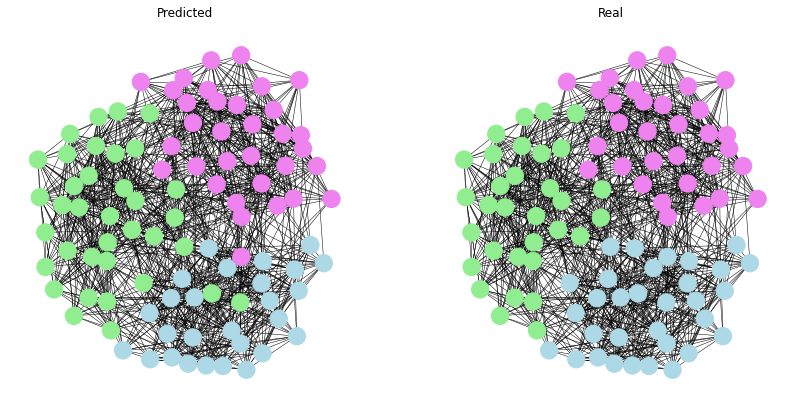

In [42]:
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
node_color = [colors[v] for v in model.predict(G, G.nodes)]
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)
plt.title("Predicted")
plt.subplot(1, 2, 2)
node_color = [colors[v] for v in y]
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)
plt.title("Real")

## Belief propagation / Message passing
- [Wikipedia entry](https://en.wikipedia.org/wiki/Belief_propagation)
- [paper](https://arxiv.org/ftp/arxiv/papers/1301/1301.6725.pdf)

*Intuition*:
- Nodes "talk" about their label to each other by sending messages 
- message = node $u$ is sure $v$ is of class $Y_v$ with some probability
- Because we assumed that similar nodes cluster together we hope to converge somewhere and classify the nodes


Algorithm:
Suppose we are in node $i$
1. Node $i$ gets messages from the incoming neighbours $(u, v, k)$
2. Node $i$ computes his new message using his information and the incoming information 
3. Node $i$ passes his message formard to the next node $j$

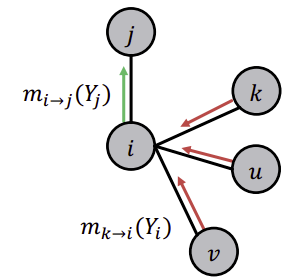

**Example: Node counting**

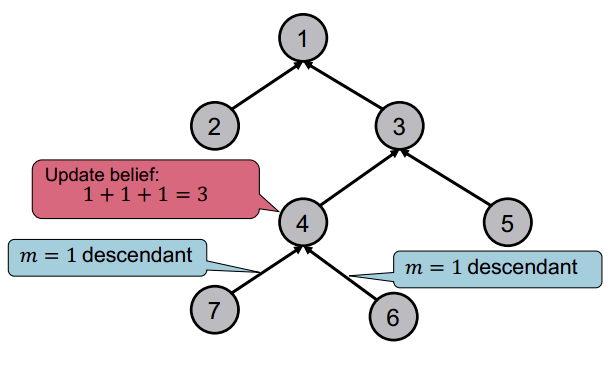

**What about cycles?**  
If we don't have cycles we can order a nodes in an advantageous way (Ex: trees start from bottom up). When cycles appear we can't do that anymore. Therefore we start for arbitrary nodes. We can still run the algorithm but messages will not be independent (they will come back in loops). Therefore we can just run a small number of iterations


**Pros**
- Easy to code and parallelize
- Can apply to any graph model
**Cons**
- Convergence not guaranteed
- Loops might make the process hard -> Only use a small number of iterations

**Is this useful?**
- Real world graphs tend to have branches (look like trees) or have long cycles. Thereofre this is a good heuristic